## Text Classification

In [178]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [179]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
10609,16667,61619,"Vancouver Island BC, Canada ?",21-03-2020,Did a little online shopping today and support...,Extremely Positive
21277,29750,74702,"Toronto, ON",01-04-2020,Local food banks prepare for sharp increase in...,Positive
1254,5319,50271,"Vineland, Ontatio",17-03-2020,RETAIL STORE UPDATE. \r\r\nThe continued healt...,Positive
5700,10721,55673,Nashville,19-03-2020,If anyone calls you to get your info to send y...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



In [ ]:
positives = ['Positive', 'Extremely Positive']
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x in positives else 0 )
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
27463,37473,82425,"Copenhagen, Denmark",08-04-2020,A great article outlining how consumer behavio...,1
30661,41509,86461,"Hatfield, UK",10-04-2020,@wearyrabbit Hi there - We're working closely ...,1
18520,26338,71290,Liverpool,25-03-2020,Just seen this in @MetroUK and thought it was ...,1
11472,17709,62661,Hampshire. Just the old one.,21-03-2020,Easy solution to stop panic buying: close supe...,0


In [ ]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

Позитивных твитов на 9% от общего количества больше, то есть данные сбалансированы неидеально, но не все так плохо.

In [ ]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [183]:
df['Location'].fillna('Unknown')

0                                  UK
1                           Vagabonds
2                             Unknown
3                             Unknown
4         ÃÂT: 36.319708,-82.363649
                     ...             
33439                            OHIO
33440                         Unknown
33441                         Unknown
33442                         Unknown
33443    i love you so much || he/him
Name: Location, Length: 33444, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
d = {}

for i, row in train.iterrows():
    tweet = row['OriginalTweet']
    tokens = tweet.lower().split()
    for t in tokens:
        if t not in d.keys():
            d[t] = 0
        d[t] += 1

In [ ]:
top_10 = sorted(d.items(), key=lambda x: x[1], reverse=True)[:10]
for t, p in top_10:
    print(t,p)

the 26815
to 23373
and 14684
of 13012
a 11737
in 11198
for 8566
#coronavirus 8223
is 7383
are 7050


Наибольшей частотой обладают артикли, предлоги и союзы(очевидно, потому что это особенность речи), а также хэштег coronavirus, потому что это твиты про это заболевание. Сюда также попали глаголы is и am, потому что они тоже часто употребляются, что вызвано грамматикой английского языка.

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords") 
stop_words = set(stopwords.words("english"))
for stop in stop_words:
    if stop in d.keys():
        d.pop(stop)

In [ ]:
from nltk.tokenize import TweetTokenizer

tk = TweetTokenizer()

d = {}

for i, row in train.iterrows():
    tweet = row['OriginalTweet']
    tokens = tk.tokenize(tweet)
    for t in tokens:
        if t not in d.keys():
            d[t] = 0
        d[t] += 1

In [ ]:
def custom_tokenizer(text):
  text = text.lower()
  tk = TweetTokenizer()
  tokens = tk.tokenize(text)
  ts = [t for t in tokens if t not in stop_words and t not in punctuation and not (len(t) == 1 and ord(t) >= 128) and not t.startswith('https://t.co/')]

  return ts

In [197]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

In [198]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv_table = cv.fit_transform(train.OriginalTweet)
print(len(cv.vocabulary_))

45308


In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

In [216]:
text = train.iloc[ind]['OriginalTweet']
text

'Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs'

In [ ]:
vectorized_text = cv.transform([text]).toarray()
vectorized_text

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [218]:
max_index = np.argmax(vectorized_text)
min_index = np.min(vectorized_text[np.nonzero(vectorized_text)])

vocab = cv.vocabulary_
inverse_vocab = {index: token for token, index in vocab.items()}

most_important_token = inverse_vocab[max_index]
least_important_token = inverse_vocab[min_index]

print(f"Самый важный токен: {most_important_token}")
print(f"Самый неважный токен: {least_important_token}")

Самый важный токен: #coronavirusoutbreak
Самый неважный токен: ##coronavirus


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_table = tfidf_v.fit_transform(train.OriginalTweet)

In [220]:
arr = tfidf_v.transform([train.iloc[ind]["OriginalTweet"]]).toarray()[0]

print(np.where(arr == arr.max()))

arr[arr == 0] = arr.max() + 1
print(np.where(arr == arr.min()))

(array([20553], dtype=int64),)
(array([27042], dtype=int64),)


In [222]:
print("Важный:   ", tfidf_v.get_feature_names_out()[20553])
print("Неважный: ", tfidf_v.get_feature_names_out()[27042])

Важный:    brainless
Неважный:  food


In [ ]:
cv_table = cv.fit_transform(train.OriginalTweet)
tfidf_table = tfidf_v.fit_transform(train.OriginalTweet)
y_train = train.Sentiment
y_test = test.Sentiment

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

cv_table_test = cv.transform(test.OriginalTweet)

clf = LogisticRegression(max_iter=200, random_state=0)
clf.fit(cv_table, y_train)
print("train: ", accuracy_score(y_train, clf.predict(cv_table)))
print("test:  ", accuracy_score(y_test, clf.predict(cv_table_test)))

tfidf_table_test = tfidf_v.transform(test.OriginalTweet)

clf = LogisticRegression(max_iter=200, random_state=0)
clf.fit(tfidf_table, y_train)
print("train: ", accuracy_score(y_train, clf.predict(tfidf_table)))
print("test:  ", accuracy_score(y_test, clf.predict(tfidf_table_test)))

train:  0.984280222127296
test:   0.8673510065776361
train:  0.9244340025630072
test:   0.8534981064381104


In [ ]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
    text = text.lower()
    tk = TweetTokenizer()
    tokens = tk.tokenize(text)
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(t) for t in tokens]
    ts = [t for t in tokens if t not in stop_words and t not in punctuation and not (len(t) == 1 and ord(t) >= 128) and not t.startswith('https://t.co/')]

    return ts

In [ ]:
cv_table_test = cv.transform(test.OriginalTweet)

clf = LogisticRegression(max_iter=200, random_state=0)
clf.fit(cv_table, y_train)
print("train: ", accuracy_score(y_train, clf.predict(cv_table)))
print("test:  ", accuracy_score(y_test, clf.predict(cv_table_test)))


tfidf_table_test = tfidf_v.transform(test.OriginalTweet)

clf = LogisticRegression(max_iter=200, random_state=0)
clf.fit(tfidf_table, y_train)
print("train: ", accuracy_score(y_train, clf.predict(tfidf_table)))
print("test:  ", accuracy_score(y_test, clf.predict(tfidf_table_test)))

train:  0.9690730457069628
test:   0.8631652381901534
train:  0.9151644596326356
test:   0.85519234602352


In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=0.34).fit(train.OriginalTweet)
print(len(cv_df.vocabulary_))

36619


In [ ]:
from sklearn.preprocessing import StandardScaler

train_mat = cv_df.transform(train.OriginalTweet).toarray()
test_mat = cv_df.transform(test.OriginalTweet).toarray()

scaler = StandardScaler()
train_mat = scaler.fit_transform(train_mat)
test_mat = scaler.transform(test_mat)

clf = LogisticRegression(max_iter=200, random_state=0)
clf.fit(train_mat, y_train)
print("train: ", accuracy_score(y_train, clf.predict(train_mat)))
print("test:  ", accuracy_score(y_test, clf.predict(test_mat)))

train:  0.9414780008543358
test:   0.8450269085110624


<Axes: xlabel='weight', ylabel='token'>

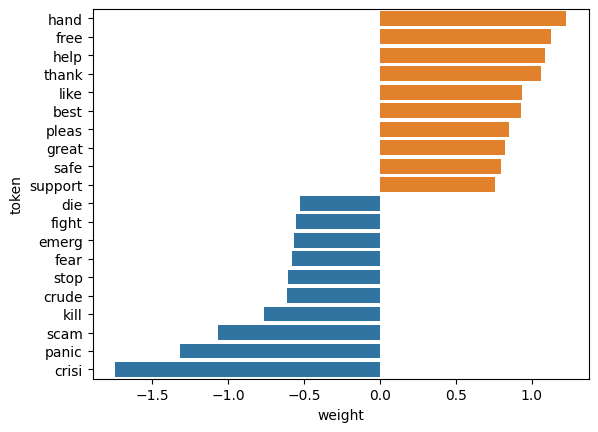

In [300]:
data = {
    "token": cv_df.get_feature_names_out(),
    "weight": clf.coef_[0],
}

tokens_weights = pd.DataFrame(data)
tokens_weights = tokens_weights.sort_values("weight", ascending=False)
tw = tokens_weights.drop(tokens_weights.index[10:-10])

sns.barplot(tw, y="token", x="weight", hue=(tw.weight > 0), legend=False)

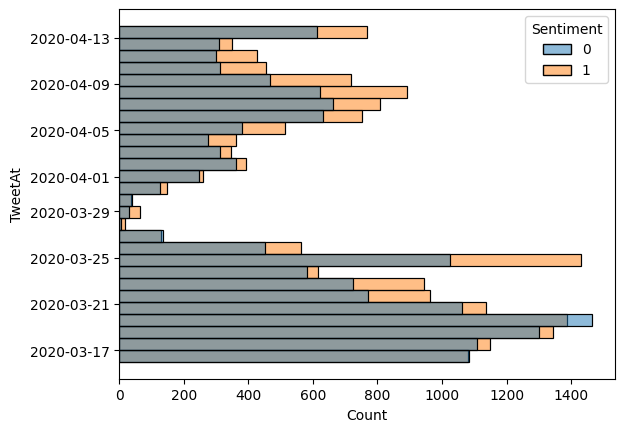

In [ ]:
df.TweetAt = pd.to_datetime(df.TweetAt)
sns.histplot(df, y="TweetAt", hue=df.Sentiment);

Location
London             435
United States      416
London, England    413
Washington, DC     317
New York, NY       302
United Kingdom     286
Los Angeles, CA    218
India              216
UK                 187
USA                178
Name: count, dtype: int64


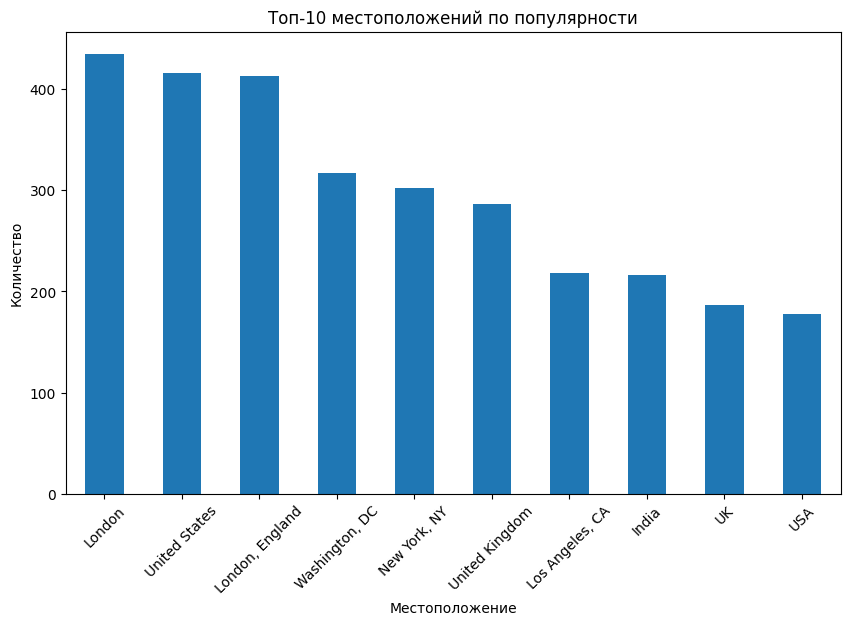

In [ ]:
location_counts = df[df['Location'] != 'Unknown']['Location'].value_counts()

top_10_locations = location_counts.head(10)
print(top_10_locations)

plt.figure(figsize=(10, 6))
top_10_locations.plot(kind='bar')
plt.title('Топ-10 местоположений по популярности')
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Количество уникальных категорий в WiderLocation: 6118
WiderLocation
USA               1407
England           1286
CA                 868
India              787
UK                 565
London             559
United Kingdom     552
NY                 552
Canada             442
United States      432
Name: count, dtype: int64


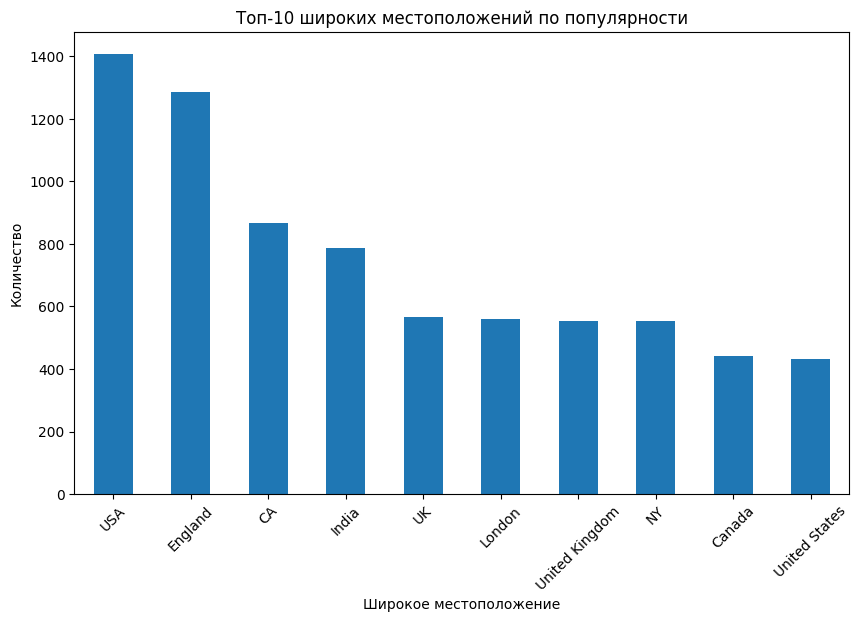

In [ ]:
df['WiderLocation'] = df['Location'].apply(lambda x: x.split(',')[-1].strip() if pd.notna(x) else 'Unknown')

unique_wider_locations = df['WiderLocation'].nunique()
print(f'Количество уникальных категорий в WiderLocation: {unique_wider_locations}')

wider_location_counts = df[df['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts()

top_10_wider_locations = wider_location_counts.head(10)
print(top_10_wider_locations)

plt.figure(figsize=(10, 6))
top_10_wider_locations.plot(kind='bar')
plt.title('Топ-10 широких местоположений по популярности')
plt.xlabel('Широкое местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

In [337]:
df['WiderLocation'] = df['Location'].apply(lambda x: x.split(',')[-1].strip() if pd.notna(x) else 'Unknown')

location_counts = df['WiderLocation'].value_counts()

locations_more_than_once = location_counts[location_counts > 1].index

filtered_df = df[df['WiderLocation'].isin(locations_more_than_once)]

ohe_df = pd.get_dummies(filtered_df['WiderLocation'])

unique_locations_count = len(ohe_df.columns)
print(f'Количество уникальных значений, встречающихся более одного раза: {unique_locations_count}')

Количество уникальных значений, встречающихся более одного раза: 1308
